In [1]:
import os
import matplotlib.pyplot as pit
from nilearn import image as img
from nilearn import plotting as plot
from bids.layout import BIDSLayout
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
#base directory
fmriprep_dir='Full-Dataset'
layout=BIDSLayout(fmriprep_dir)

In [3]:
t1_files=layout.get(subject='01',datatype='anat',extension='.nii.gz',return_type="file")
func_files=layout.get(subject='01',datatype='func',extension='.nii.gz',return_type="file")

In [4]:
func_img=img.load_img(func_files)

In [5]:
func_img.shape

(96, 96, 32, 341)

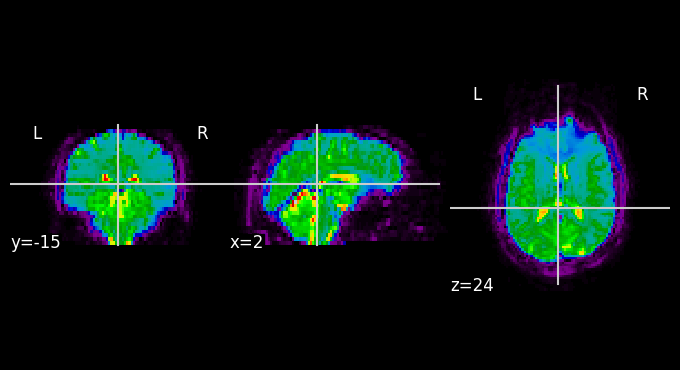

In [6]:
func_vol5=func_img.slicer[:,:,:,100]
plot.plot_epi(func_vol5)

We've represented fMRI as a snapshot of MR signal over multiple timepoints. This is a useful way
of understanding the organization of however it isn't typically how we think about the data
when we analyze fMRI data. fMRI is typically thought of as time-series data. We can think of each
voxel (x.y.z coordinate) as having a time-series of length T. The length T represents the number of
volumes/timepoints in the data. Let's pick an example voxel and examine its time-series using
```func_mni_img.slicer```:

In [7]:
#Pick one Voxel at coordinate (60,45,88)
single_vox=func_img.slicer[59:60,45:46,30:31,:].get_fdata()
single_vox.shape

(1, 1, 1, 341)

In [8]:
single_vox=single_vox.flatten()
single_vox.shape

(341,)

Text(0, 0.5, 'Signal Value')

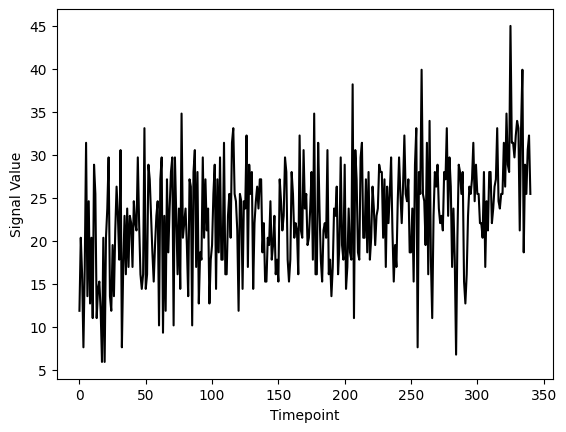

In [9]:
plt.plot(np.arange(0,single_vox.shape[0]),single_vox,'k')
plt.xlabel('Timepoint')
plt.ylabel('Signal Value')

In [42]:
import statsmodels.api as sm

# Instantiate the GLM
model = sm.GLM(single_vox, np.arange(0, single_vox.shape[0]))

# Fit the model
results = model.fit()
# Print the summary of results
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  341
Model:                            GLM   Df Residuals:                      340
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          124.91
Method:                          IRLS   Log-Likelihood:                -1306.5
Date:                Sun, 29 Oct 2023   Deviance:                       42470.
Time:                        23:44:12   Pearson chi2:                 4.25e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            -0.9569
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1057      0.003     34.311      0.0

Recall from our introductory exploration of neuroimaging data:

    (*) TI images are typically composed of voxels that are 1x1x1 in dimension

    (*) Functional images are typically composed of voxels that are 4x4x4 in dimension
    
If we'd like to overlay our functional on top of our Tl (for visualization purposes, or analyses), then
we need to match the size of the voxels!
Think Of this like trying to overlay a 10x10 JPEG and a 20x20 JPEG on top Of each other. TO get
perfect overlay we need to resize (or more accurately resample) our JPEGs to match!

**Note:** Resampling is a method of interpolating in between data-points. When we stretch an image
we need to figure out what goes in the spaces that are created via stretching - resampling does
just that. In fact, resizing any type of image is actually just resampling to new dimensions.
Let's resampling some MRI data using nilearn.

**Goal:** Match the dimensions of the structural image to that of the functional image

In [23]:
t1_mni=t1_files
t1_mni_img=img.load_img(t1_mni)

In [24]:
print(t1_mni_img.shape)
print(func_img.shape)

(240, 240, 180, 1)
(96, 96, 32, 341)


A note on **interpolation**
nileam supports 3 types of interpolation, the one you'll use depends on the type of data you're
resampling!
1. **continuous** - Interpolate but maintain some edge features. Ideal for structural images where
edges are well-defined. Uses 3rd -order spline interpolation.
2. **linear (default)** - Interpolate uses a combination Of neighbouring voxels - will blur. Uses
trilinear interpolation.
3. **nearest** - matches value of clbsest voxel (majority vote from neighbours). This is ideal for
masks which are binary since it will preserve the 0's and I's and will not produce in-between
values (ex: 0.342). Also ideal for numeric labels where values are 0,1,2,3...(parcellations).
IJses nearest-neighbours interpolation with majority vote.